# Introduction to Audio Data

In [2]:
import librosa 

array, sampling_rate = librosa.load(librosa.ex("trumpet"))

## Audio as a waveform

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


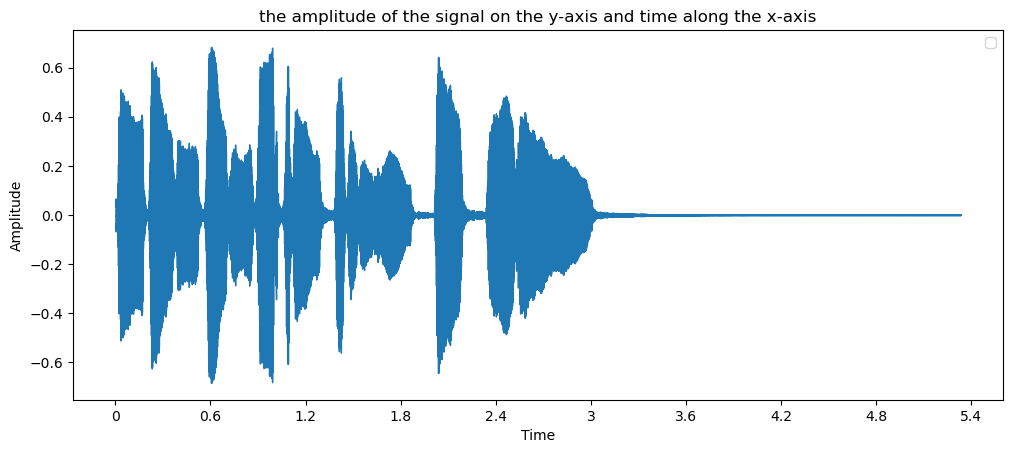

In [9]:
import matplotlib.pyplot as plt
import librosa.display

plt.figure().set_figwidth(12)
plt.title("the amplitude of the signal on the y-axis and time along the x-axis")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.legend()
librosa.display.waveshow(array, sr=sampling_rate)

## The frequency spectrum

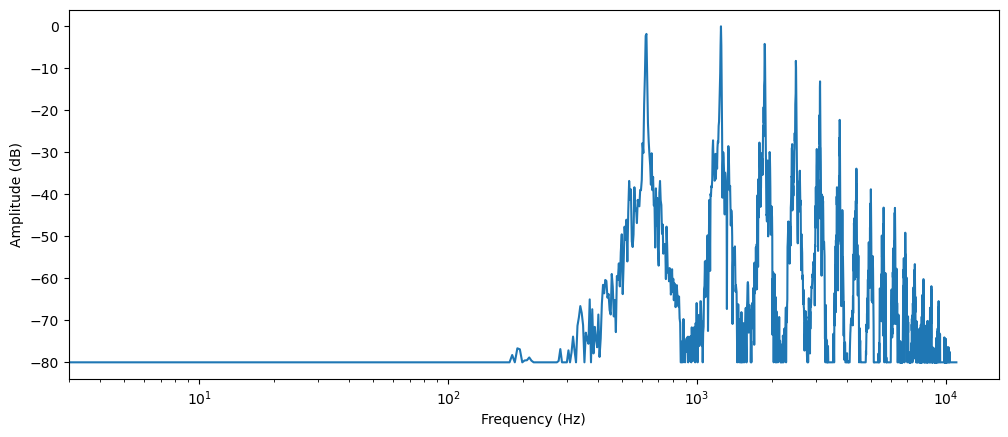

In [12]:
import numpy as np

dft_input = array[:5000]

# calculate the DFT
window = np.hanning(len(dft_input))
windowed_input = dft_input * window
dft = np.fft.rfft(windowed_input)

# get the amplitude spectrum in decibels
amplitude = np.abs(dft)
amplitude_db = librosa.amplitude_to_db(amplitude, ref=np.max)

# get the frequency bins
frequency = librosa.fft_frequencies(sr=sampling_rate, n_fft=len(dft_input))

plt.figure().set_figwidth(12)
plt.plot(frequency, amplitude_db)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude (dB)")
plt.xscale("log")

## Spectrogram

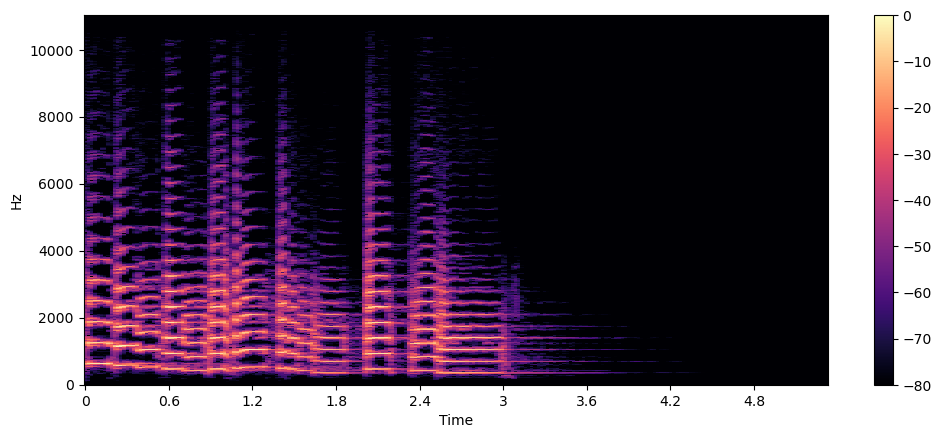

In [13]:
import numpy as np

D = librosa.stft(array)
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

plt.figure().set_figwidth(12)
librosa.display.specshow(S_db, x_axis="time", y_axis="hz")
plt.colorbar()

## Mel spectrogram

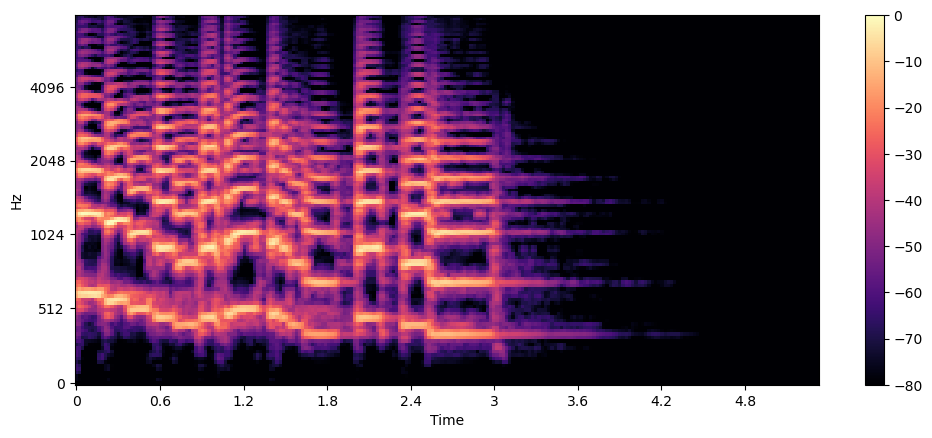

In [16]:
S = librosa.feature.melspectrogram(y=array, sr=sampling_rate, n_mels=128, fmax=8000)
S_dB = librosa.power_to_db(S, ref=np.max)

plt.figure().set_figwidth(12)
librosa.display.specshow(S_dB, x_axis="time", y_axis="mel", sr=sampling_rate, fmax=8000)
plt.colorbar()

# Exploring an Audi Dataset

In [89]:
from datasets import load_dataset

minds = load_dataset("PolyAI/minds14", name="en-AU", split="train")
minds

Found cached dataset minds14 (C:/Users/furka/.cache/huggingface/datasets/PolyAI___minds14/en-AU/1.0.0/7bdf27fccad4efc6da7c00f739d96bfa0d25a7a85f2244755a73c865f70182bc)


Dataset({
    features: ['path', 'audio', 'transcription', 'english_transcription', 'intent_class', 'lang_id'],
    num_rows: 654
})

In [34]:
example = minds[0]
example

{'path': 'C:\\Users\\furka\\.cache\\huggingface\\datasets\\downloads\\extracted\\0254525c29529d1916d49e22775fa58c67ef650389b27f8bba54af8a1aa9db37\\en-AU~PAY_BILL\\response_4.wav',
 'audio': {'path': 'C:\\Users\\furka\\.cache\\huggingface\\datasets\\downloads\\extracted\\0254525c29529d1916d49e22775fa58c67ef650389b27f8bba54af8a1aa9db37\\en-AU~PAY_BILL\\response_4.wav',
  'array': array([ 0.        ,  0.00024414, -0.00024414, ..., -0.00024414,
          0.00024414,  0.0012207 ]),
  'sampling_rate': 8000},
 'transcription': 'I would like to pay my electricity bill using my card can you please assist',
 'english_transcription': 'I would like to pay my electricity bill using my card can you please assist',
 'intent_class': 13,
 'lang_id': 2}

In [36]:
id2label = minds.features["intent_class"].int2str
id2label(example["intent_class"])

'pay_bill'

In [37]:
columns_to_remove = ["lang_id", "english_transcription"]
minds = minds.remove_columns(columns_to_remove)
minds

Dataset({
    features: ['path', 'audio', 'transcription', 'intent_class'],
    num_rows: 654
})

In [57]:
import gradio as gr


def generate_audio():
    example = minds.shuffle()[0]
    audio = example["audio"]
    return (
        audio["sampling_rate"],
        audio["array"],
    ), id2label(example["intent_class"])

audio

(8000,
 array([ 0.        ,  0.00024414, -0.00024414, ...,  0.        ,
         0.        ,  0.        ]))

In [ ]:
with gr.Blocks() as demo:
    with gr.Column():
        for _ in range(4):
            audio, label = generate_audio()
            # output = gr.Audio(value=audio, label=label)

demo.launch(debug=True)

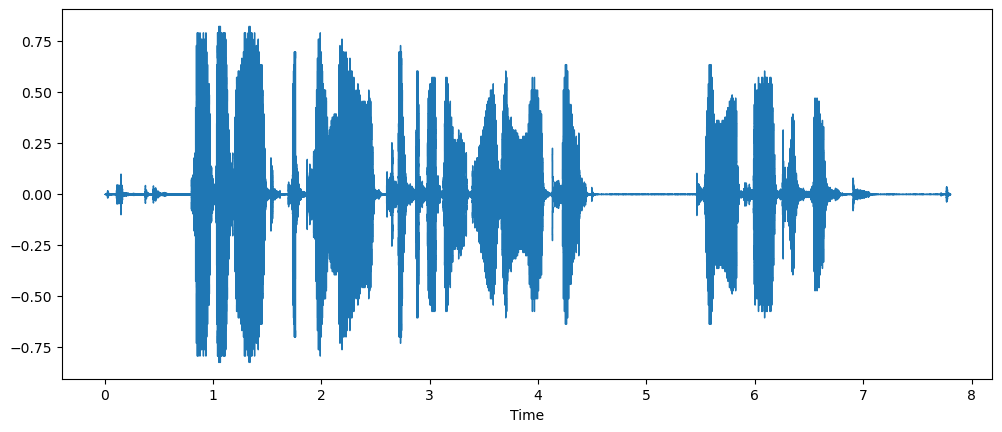

In [59]:
import librosa
import matplotlib.pyplot as plt
import librosa.display

array = example["audio"]["array"]
sampling_rate = example["audio"]["sampling_rate"]

plt.figure().set_figwidth(12)
librosa.display.waveshow(array, sr=sampling_rate)

# Preprocessing audio data

In [90]:
from datasets import Audio

minds = minds.cast_column("audio", Audio(sampling_rate=16_000))

## Resampling the audio data

In [91]:
minds[0]

{'path': 'C:\\Users\\furka\\.cache\\huggingface\\datasets\\downloads\\extracted\\0254525c29529d1916d49e22775fa58c67ef650389b27f8bba54af8a1aa9db37\\en-AU~PAY_BILL\\response_4.wav',
 'audio': {'path': 'C:\\Users\\furka\\.cache\\huggingface\\datasets\\downloads\\extracted\\0254525c29529d1916d49e22775fa58c67ef650389b27f8bba54af8a1aa9db37\\en-AU~PAY_BILL\\response_4.wav',
  'array': array([2.36120541e-05, 1.92325111e-04, 2.19284673e-04, ...,
         9.40908678e-04, 1.16613181e-03, 7.20883720e-04]),
  'sampling_rate': 16000},
 'transcription': 'I would like to pay my electricity bill using my card can you please assist',
 'english_transcription': 'I would like to pay my electricity bill using my card can you please assist',
 'intent_class': 13,
 'lang_id': 2}

## Filtering the dataset

In [92]:
MAX_DURATION_IN_SECONDS = 20.0

def is_audio_length_in_range(input_length):
    return input_length < MAX_DURATION_IN_SECONDS

In [93]:
# use librosa to get example's duration from the audio file
new_column = [librosa.get_duration(path=x) for x in minds["path"]]
minds = minds.add_column("duration", new_column)

# use 🤗 Datasets' `filter` method to apply the filtering function
minds = minds.filter(is_audio_length_in_range, input_columns=["duration"])

# remove the temporary helper column
minds = minds.remove_columns(["duration"])
minds

Filter:   0%|          | 0/654 [00:00<?, ? examples/s]

Dataset({
    features: ['path', 'audio', 'transcription', 'english_transcription', 'intent_class', 'lang_id'],
    num_rows: 624
})

## Whisper

In [96]:
from transformers import WhisperFeatureExtractor

feature_extractor = WhisperFeatureExtractor.from_pretrained("openai/whisper-small")

In [98]:
def prepare_dataset(example):
    audio = example["audio"]
    features = feature_extractor(
        audio["array"], sampling_rate=audio["sampling_rate"], padding=True
    )
    return features

In [101]:
minds = minds.map(prepare_dataset)
minds

Map:   0%|          | 0/624 [00:00<?, ? examples/s]

Dataset({
    features: ['path', 'audio', 'transcription', 'english_transcription', 'intent_class', 'lang_id', 'input_features'],
    num_rows: 624
})

### How the whisper input data looks like after preprocessing

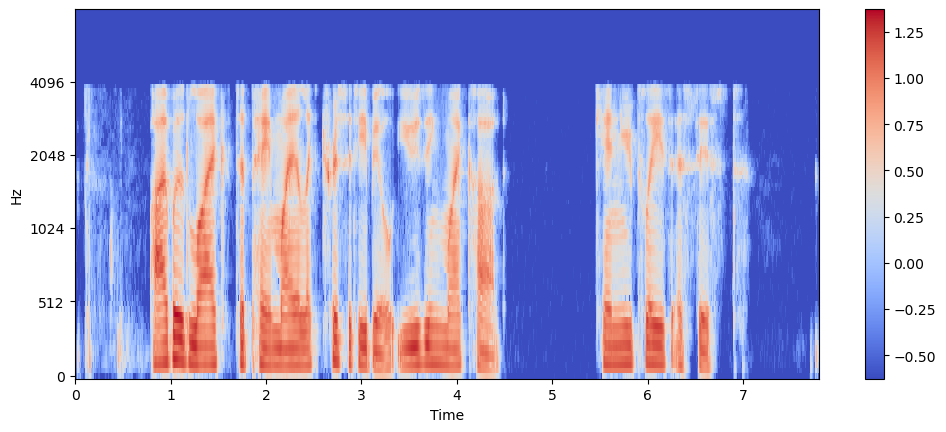

In [100]:
import numpy as np

example = minds[0]
input_features = example["input_features"]

plt.figure().set_figwidth(12)
librosa.display.specshow(
    np.asarray(input_features[0]),
    x_axis="time",
    y_axis="mel",
    sr=feature_extractor.sampling_rate,
    hop_length=feature_extractor.hop_length,
)
plt.colorbar()

In [104]:
from transformers import AutoProcessor

processor = AutoProcessor.from_pretrained("openai/whisper-small")

# Streaming Audio Data